In [2]:
# Final project sta 141c
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import parallel_backend
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

os.chdir("C:\\Users\Rohan\Downloads")

# Data processing
precovid = pd.read_csv('precovid_reviews.csv')
postcovid = pd.read_csv('postcovid_reviews.csv')

cols = ['business_id', 'name', 'address', 'latitude', 'longitude', 'is_open', 'categories', 'hours', 'review_count']
merger = pd.merge(precovid, postcovid, on = cols)
merger = merger[merger['is_open'] != 0] # get rid of closed restaurants





### Formatting data for analysis

In [3]:
business_ids = pd.concat([merger['business_id'], merger['business_id']]).reset_index(drop = True) # merge before and after business ids for creation of sparse matrix later
## will help format matrix for SVD 

bus_stars = pd.concat([merger['stars_x'], merger['stars_y']]).reset_index(drop = True)
user_ids = pd.concat([merger['user_id_x'], merger['user_id_y']]).reset_index(drop = True) # merge pre and post covid data by column
stars = pd.concat([merger['customer_stars_x'], merger['customer_stars_y']]).reset_index(drop = True)
dates = pd.concat([merger['date__x'], merger['date__y']]).reset_index(drop = True)
names = pd.concat([merger['name'], merger['name']]).reset_index(drop = True)
addresses = pd.concat([merger['address'], merger['address']]).reset_index(drop = True)
state = pd.concat([merger['state__x'], merger['state__y']]).reset_index(drop = True)
city = pd.concat([merger['city_x'], merger['city_y']]).reset_index(drop = True)
postal_code = pd.concat([merger['postal_code_x'], merger['postal_code_y']]).reset_index(drop = True)
useful = pd.concat([merger['useful_x'], merger['useful_y']]).reset_index(drop = True)
funny = pd.concat([merger['funny_x'], merger['funny_y']]).reset_index(drop = True)
cool = pd.concat([merger['cool_x'], merger['cool_y']]).reset_index(drop = True)


businesses2 = [business_ids, user_ids, stars, useful, funny, cool, dates, names, addresses, state, city, postal_code, bus_stars]
businesses3 = pd.concat(businesses2, axis = 1) # combine pre and post covid data
businesses4 = businesses3.rename(columns = {'business_id': 'business_id', 0: 'user_id', 1: 'stars', 2: 'useful', 3: 'funny', 4: 'cool', 5: 'date', 'name': 'name', 'address': 'address', 6 :'state', 7 : 'city', 8 : 'postal_code', 9: 'bus_stars'})

s_mat = businesses4.pivot_table(values = 'stars', index = 'user_id', columns = 'name', fill_value= 0).drop_duplicates(keep = False) # create sparse matrix with customer stars
s_mat.shape

res_names = s_mat.columns.tolist()
businesses5 = businesses4.loc[businesses4['name'].isin(res_names)]
# businesses4.groupby('name')['stars'].count().sort_values(ascending = False)



### Descriptive Statistics

In [28]:
avg_bus_stars = bus_stars.sum() / len(bus_stars) # calculate average overall stars
avg_cust_stars = stars.sum() / len(stars)
avg_rev_counts = merger['review_count'].sum() / len(merger['review_count'])
useful_avg = useful.sum() / len(useful)
funny_avg = funny.sum() / len(funny)
cool_avg = cool.sum() / len(cool)

averages = [avg_bus_stars, avg_cust_stars, useful_avg, funny_avg, cool_avg, avg_rev_counts]

bus_star_mode = bus_stars.mode().values[0] # calculate mode for overall stars
cust_stars_mode = stars.mode().values[0]
useful_mode = useful.mode().values[0]
funny_mode = funny.mode().values[0]
cool_mode = cool.mode().values[0]
rev_counts_mode = merger['review_count'].mode().values[0]

modes = [bus_star_mode, cust_stars_mode, useful_mode, funny_mode, cool_mode, rev_counts_mode]

bus_star_std = bus_stars.std() # calculate standard deviation for overall stars
cust_stars_std = stars.std()
useful_std = useful.std()
funny_std = funny.std()
cool_std = cool.std()
rev_counts_std = merger['review_count'].std()

stds = [bus_star_std, cust_stars_std, useful_std, funny_std, cool_std, rev_counts_std]

bus_star_median = bus_stars.median() # calculate median for overall stars
cust_stars_median = stars.median()
useful_median = useful.median()
funny_median = funny.median()
cool_median = cool.median()
rev_counts_median = merger['review_count'].median()

medians = [bus_star_median, cust_stars_median, useful_median, funny_median, cool_median, rev_counts_median]

data = {'Mean': averages, 'Median': medians, 'Mode': modes, 'Standard Deviation': stds}

des_stats = pd.DataFrame(data = data)
des_stats.index = ['Overall Stars', 'Customer Stars', 'Useful', 'Funny', 'Cool', 'Number of Reviews']
des_stats.T

,Overall Stars,Customer Stars,Useful,Funny,Cool,Number of Reviews
Mean,4.179587,4.173274,0.788767,0.298166,0.504876,2679.657661
Median,4.500000,5.000000,0.000000,0.000000,0.000000,2435.000000
Mode,4.500000,5.000000,0.000000,0.000000,0.000000,3761.000000
Standard Deviation,0.444880,1.193325,2.722549,1.622924,2.384565,1921.518831


### SVD

In [3]:
A = s_mat.values.T # extract numerical values for SVD 
svd = TruncatedSVD(n_components=800, random_state=12, algorithm = 'randomized') 

with parallel_backend('multiprocessing', n_jobs = -1): # runs SVD on all processes available to system
    #u,s,vt = randomized_svd(A, n_components = 800, random_state = 21)
    res_matrix = svd.fit_transform(A) 
    corr_matrix = np.corrcoef(res_matrix)
    usig = res_matrix # is actually u * sigma 
    s = svd.singular_values_
    vt = svd.components_
    ex_var_rat = svd.explained_variance_ratio_

#print("U: ", u.shape, "S: ", s.shape, "V: ", vt.shape)
#sparse = 1 - np.count_nonzero(A) / A.size # sparsity of matrix

C:\Users\Rohan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Rohan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [71]:
svd2 = TruncatedSVD(n_components=2847, random_state=1, algorithm = 'randomized') # SVD to determine number of ideal components 

with parallel_backend('threading', n_jobs = -1): # runs SVD on all threads available
    #u,s,vt = randomized_svd(A, n_components = 800, random_state = 21)
    res2_matrix = svd2.fit_transform(A) 
    corr2_matrix = np.corrcoef(res2_matrix)
    usig2 = res_matrix # is actually u * sigma 
    s2 = svd2.singular_values_
    vt2 = svd2.components_
    ex_var_rat2 = svd2.explained_variance_ratio_


C:\Users\Rohan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Rohan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### K-Means Clustering

In [75]:
kmeans = KMeans(n_clusters=2, random_state=3) # k means clustering to cluster restaurants by the number of stars they received
kmeans.fit(res_matrix)

user_cluster = kmeans.predict(res_matrix) 
centers = np.array(kmeans.cluster_centers_)


### Graphs

Text(0.5, 1.0, 'Variance Explained by Components')

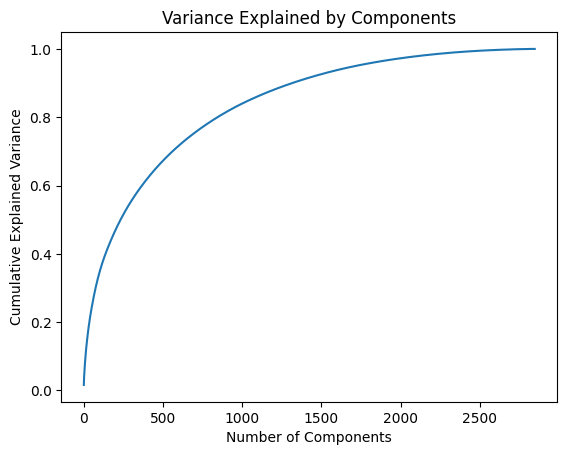

In [72]:
plt.plot(np.cumsum(ex_var_rat2))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Components')

Text(0.5, 1.0, 'Variance Explained by Components')

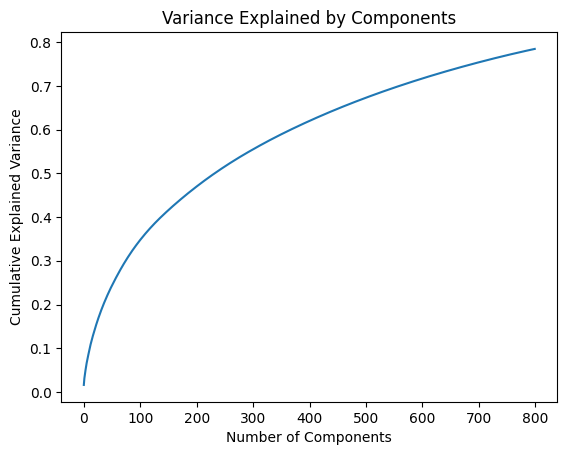

In [73]:
plt.plot(np.cumsum(ex_var_rat))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Components')

Text(0.5, 1.0, 'Variance Explained by Features')

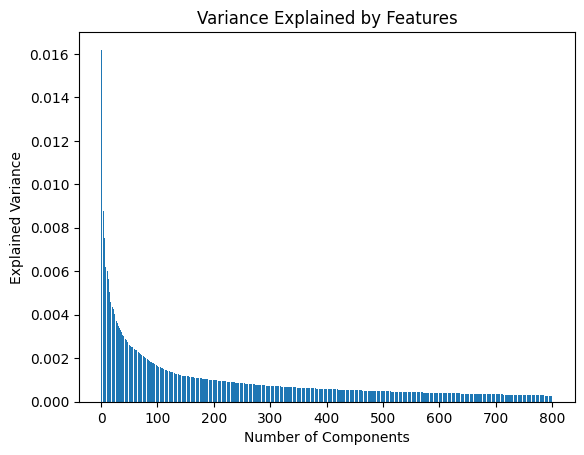

In [74]:
plt.bar(range(1, len(ex_var_rat) + 1), ex_var_rat)
plt.ylabel('Explained Variance')
plt.xlabel('Number of Components')
plt.title('Variance Explained by Features')

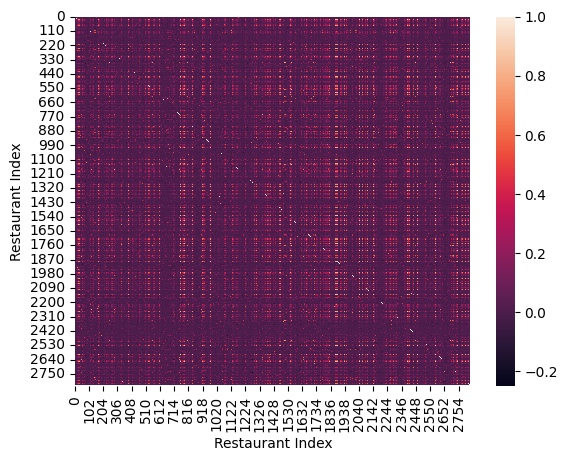

In [63]:

top_5 = businesses4.groupby('name')['stars'].count().sort_values(ascending = False)

sns.heatmap(corr_matrix)
plt.xlabel('Restaurant Index')
plt.ylabel('Restaurant Index')
plt.show()

<AxesSubplot: >

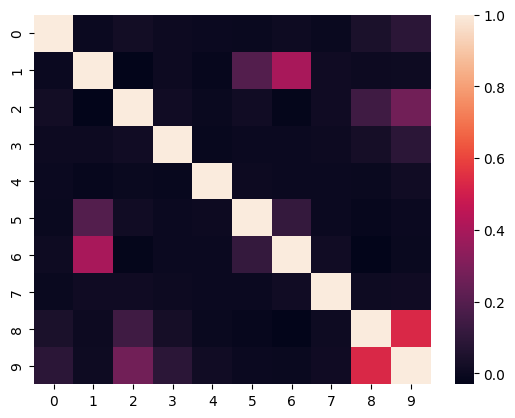

In [43]:
subset_corr = corr_matrix[10:20, 10:20]
sns.heatmap(subset_corr)


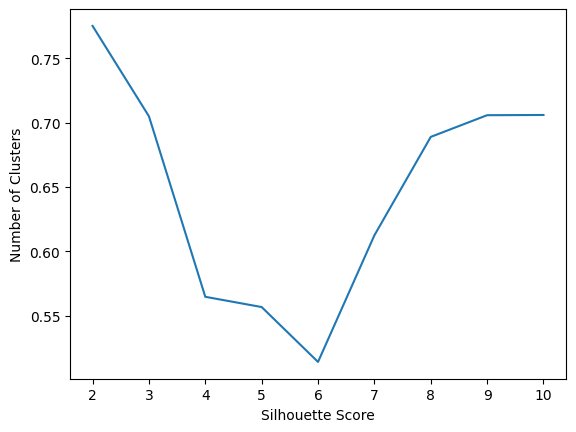

In [44]:
e = range(2, 11)


sil_scores = []
for i in e:
    kmeans = KMeans(n_clusters=i, random_state=43)
    kmeans.fit(res_matrix)
    sil_scores.append(silhouette_score(res_matrix, kmeans.labels_))

e[np.argmax(sil_scores)] # get ideal number of clusters

plt.xlabel('Silhouette Score')
plt.ylabel('Number of Clusters')
plt.plot(e, sil_scores)


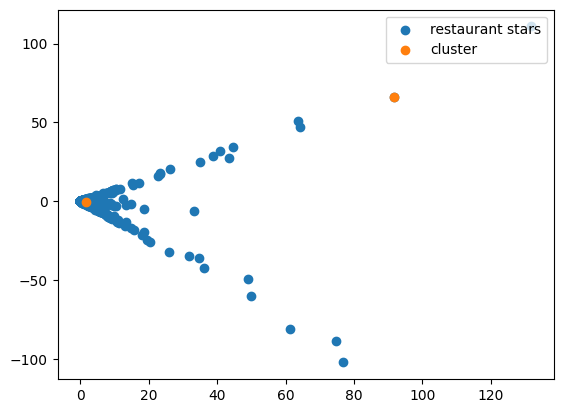

In [45]:
plt.scatter(res_matrix[:,0], res_matrix[:,1], label = 'restaurant stars')
plt.scatter(centers[:,0], centers[:,1], label = 'cluster')

plt.legend(loc = 'upper right')


### Recommendation Function

In [79]:
def top_restaurants(restaurant, n = 10, correlation_factor = 0.9):
    """
    Function returns top n correlated restaurants with given restaurant name.
    """
    
    
    selected_restaurant = int(list(s_mat.columns).index(str(restaurant))) # get index of restaurant from matrix
    recommendations = s_mat.columns[(corr_matrix[selected_restaurant] < 1.0) & (corr_matrix[selected_restaurant] > correlation_factor)].sort_values(ascending = False).values.tolist() # returns highest correlated restaurants with restaurant in index of correlation matrix
    
    

    res_df = pd.merge(businesses4, pd.DataFrame({'name': recommendations}), on = 'name').drop_duplicates(keep = False) # create dataframe that contains the info about the recommended restaurants
    res_df = res_df[['bus_stars', 'name', 'address','city', 'state']].drop_duplicates() # creating dataframe with recommended restaurants
    res_df = res_df.rename({'bus_stars': 'stars'}, axis = 1)
    restaurants = res_df.sort_values('name').drop_duplicates(subset = ['address']) # drop duplicated instances of restaurants in recommendation dataframe
    
    
    
    return restaurants[0:n].sort_values(by = ['stars'], ascending = False) 



In [82]:
top_restaurants(restaurant = "7-Eleven")

,stars,name,address,city,state
15732,4.5,Broad Street Paulie's,64 Broad St,Boston,MA
1308,4.0,P & C Market & Caribbean Cuisine,35 Lebanon St,Malden,MA
2734,3.0,7-Eleven,900 SE 164th Ave,Vancouver,WA
1860,3.0,Domino's Pizza- Bee Cave,15500 W Hwy 71,Bee Cave,TX
9852,3.0,Donair Affair,"2540 Mary Hill Road, Suite 105",Port Coquitlam,BC
5456,2.5,Dairy Queen Grill & Chill,613 Jq Adams St,Oregon City,OR
1724,2.5,Kipos Pizzeria & Restaurant,106 Bunker Hill St,Charlestown,MA
5506,2.0,Bud Light Port Paradise,1200 Red Cleveland Blvd,Sanford,FL
10792,2.0,Everett House of Pizza,722 Broadway,Everett,MA
304,2.0,Papa Gino's,134 Nahatan St,Norwood,MA


### Additional information about correlation matrix 

Matrix A, which represents our user-business-star matrix, is decomposed into $ A = U \Sigma V^{T} $, where A is a a matrix of size n by m (in our case, n = 2847 and m = 83569). Matrix U is an n x m matrix that contains information not readily apparent about the users in our dataset. Matrix $\Sigma$ is an m x m matrix that contains the top 800 singular values from the original matrix A, and matrix $V^{T} $ is a m x n matrix that contains latent features about the restaurants in our dataset. Truncated SVD returns a low-rank approximation of the user-business-star matrix (A), which is important as it will reduce the number of components in our matrix, and our recommendation system later on. The matrix returned from truncated SVD is equal to matrix $U * \Sigma$, which means that we have a matrix that contains the latent features about the users in our dataset. With this information, we can compute the Pearson correlation coefficient to create a correlation matrix and create recommendations. 

The Pearson correlation coefficient is defined as $\text{Corr}(R, C) = \frac{\text{Cov}(R,C)}{\sigma_R\sigma_C}$, where ${\text{Cov}(R,C)}$ is the covariance between the rows (R) of a matrix and the columns (C). The symbol $\sigma$ denotes the standard deviation of R and C. We can use this formula to ultimately create  By computing the correlation coefficient, we can see how related the stars that customers left at restaurants are with their preference of restaurant. We used this identity to create a function that, when given the name of a restaurant in our dataset, will return the top n restaurants with the highest correlation coefficient. 


https://web.stanford.edu/class/cs168/l/l9.pdf
